# Split analyzer and reconstructor
Eerst hadden we een model waarbij de analyzer en reconstructor in een zat. Het model moest geplitst worden om de analyzer later te gebruiken voor pretrained embedding layer.

In [1]:
import os
import joblib
import numpy as np
import tensorflow as tf
import support_functions as sf
import matplotlib.pyplot as plt
import keras.layers as layers
import sklearn.model_selection as model_selection

from keras import Sequential, Model
from keras.callbacks import Callback

In [2]:
# GPU
sf.limit_gpu_memory(6000)
sf.gpu_check()

True

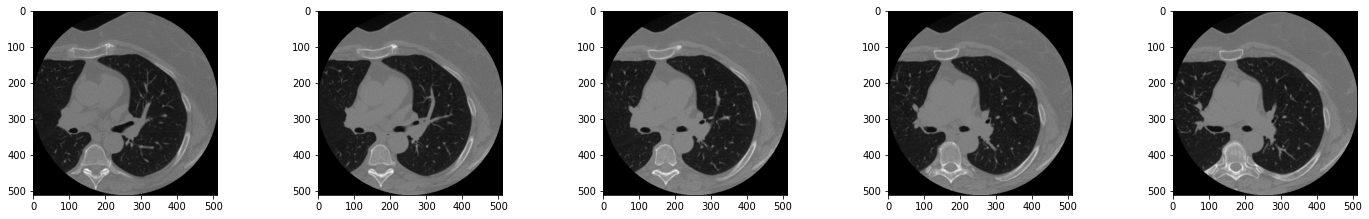

In [2]:
# Read slices
SLICES_JOBLIB_PATH = os.path.join('scans','scans_max_normalised_float32.joblib')

slices = joblib.load(SLICES_JOBLIB_PATH)

sf.display_dicom_slices(slices[0:5])

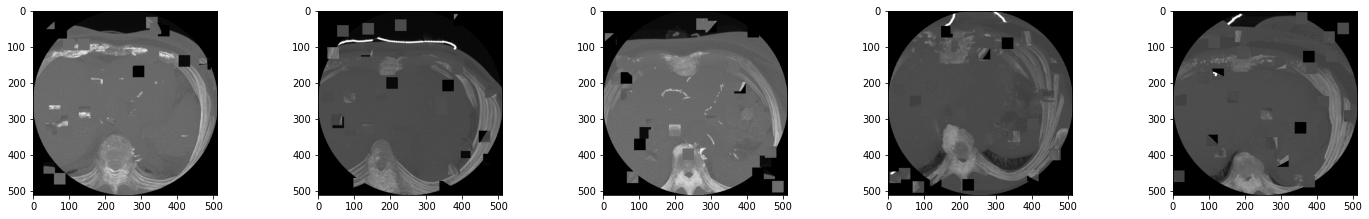

In [4]:
# Corrupt scans
NUMBER_OF_SWITCHES = 15
PATCH_SIZE = 32

corrupted_slices = np.array([sf.corrupt_image(slice, NUMBER_OF_SWITCHES, PATCH_SIZE) for slice in slices])
sf.display_dicom_slices(corrupted_slices[0:5])

#### Scans moesten geresized worden, omdat het eerst de shape (512,512) had. Dit kan niet in een Conv2D, want dat verwacht 3 dimensionaal, dus heeft het nu de shape van (512,512,1)

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(corrupted_slices, slices, test_size=0.2)

X_train = np.resize(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
y_train = np.resize(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

X_test = np.resize(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
y_test = np.resize(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

In [6]:
y_train.shape

(401, 512, 512, 1)

In [7]:
# Use mulitple GPU's
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


#### Analyzer

In [8]:
with strategy.scope():
    analyzer = Sequential(
        [
            layers.Conv2D(128, kernel_size=3, input_shape=(512,512,1), padding='same'),
            layers.Conv2D(128, kernel_size=3, padding='same'),
            layers.Conv2D(128, kernel_size=3, padding='same'),
            layers.MaxPooling2D(),

            layers.Conv2D(256, kernel_size=3, padding='same'),
            layers.Conv2D(256, kernel_size=3, padding='same'),
            layers.Conv2D(256, kernel_size=3, padding='same'),
            layers.MaxPooling2D(),
        ],
        name="analyzer",
    )
    analyzer.summary()

Model: "analyzer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 128)     1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 256)     295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 256)     590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 256)     590

#### Reconstructor

In [9]:
with strategy.scope():
    reconstructor = Sequential(
        [
            layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', input_shape=(128, 128, 256)),
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'),
            layers.Conv2D(1, kernel_size=3, padding='same'),
        ],
        name="reconstructor",
    )
    reconstructor.summary()

Model: "reconstructor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 256, 256, 256)     590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 512, 512, 128)     295040    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 512, 512, 1)       1153      
Total params: 886,273
Trainable params: 886,273
Non-trainable params: 0
_________________________________________________________________


#### Hier worden de analyzer en reconstructor bij elkaar tot 1 model

In [13]:
with strategy.scope():
    out_analyzer = analyzer.output
    out_final = reconstructor(out_analyzer)
    model = Model(analyzer.input, out_final)
    
    model.compile(optimizer='adam', loss='mse')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [14]:
MODEL_NAME = 'test_model'
CALLBACK_INTERVAL = 2

model_folder = os.path.join('models', MODEL_NAME)
os.makedirs(model_folder, exist_ok=True)

image = y_train[0]
image_corrupt = sf.corrupt_image(image, NUMBER_OF_SWITCHES, PATCH_SIZE)
image_corrupt_expanded = np.resize(image_corrupt, (1, image_corrupt.shape[0], image_corrupt.shape[1], 1))

plt.imsave(os.path.join(model_folder, 'image.png'), np.resize(image, (image.shape[0], image.shape[1])), cmap=plt.cm.gray)
plt.imsave(os.path.join(model_folder, 'image_corrupt.png'), np.resize(image_corrupt, (image_corrupt.shape[0], image_corrupt.shape[1])), cmap=plt.cm.gray)

class PredictionCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        image_predict = model.predict(image_corrupt_expanded)[0]
        sf.display_triplets(image, image_corrupt, image_predict)
        
        image_path = os.path.join(model_folder, f'{epoch:06d}.png')
        plt.imsave(image_path, np.resize(image_predict, (image_predict.shape[0], image_predict.shape[1])), cmap=plt.cm.gray)
        
class ModelSaveCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        analyzer.save(os.path.join(model_folder, 'analyzer.h5'))
        reconstructor.save(os.path.join(model_folder, 'reconstructor.h5'))
        model.save(os.path.join(model_folder, 'complete.h5'))
        

custom_callbacks = [
    PredictionCallback(),
    ModelSaveCallback()
]

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=4, validation_data=(X_test, y_test), callbacks=custom_callbacks)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()